In [9]:
# Deborah Lokhorst

# This example is an exploration of the interactions between a planet and a ring of massive
# particles.  It is intended to show the perturbation of the ring/disk of particles, as well as 
# the ring's effect on the planet.

# Much of the code of this example is based off of and taken from the spreading_ring in C 
# and SaturnsRings.ipynb.

import rebound
import numpy as np
sim = rebound.Simulation()

In [10]:
# We start out by initializing the simulation.  I set the timestep to 1% of an orbit, which allows us to capture the interactions
# between the particles in the ring.

# We want to include collisions in the simulation, since we are interested in the effect of the
# planet on the particles in the disk/ring and vice versa.
# We set the boundary to open so particles can leave without the simulation
# exiting.  We use a boxsize of about 5 AU, which should be good for our 
# simulation, since we will initialize our bodies at semi-major axes of about 1 AU.

sim.G = 1
sim.dt = 1.0e-2*2.*np.pi # 1% of an orbit
sim.softening = 0.01
sim.integrator = "leapfrog"
sim.boundary   = "open"
sim.gravity    = "tree"
sim.collision  = "tree"
boxsize = 4.8    # 4.8
sim.configure_box(boxsize,4,4,4)

# We are going to add 10000 particles, so we set a parameter for the number of particles
# to that.  We then first add a solar-type star, setting it's ID parameter to 1, and
# we also add a large planet at 1AU and set it's ID parameter to 2.
# We then move to the COM of the system.
N_particles = 10000
sim.add(id = 1,m=1., r = 0.03)
sim.add(id = 2,m=1.0e-2,a=1.,r=0.03)  # added another body in there.  changed n_active to 2.
sim.move_to_com()

In [11]:
# I implement a ring of particles, distributed in distance according to a power law,
# uniformly distributed in angle phi around the orbit and normally distributed
# in height z above the plane.  Their velocities are set to the Kepler velocity.
# I gave the particles a fairly high mass, so they should interact strongly with the planet.
def powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

N=0
while(N < N_particles):
    a   = powerlaw(slope=0.5,min_v = 0.9,max_v = 1.1)
    phi = np.random.uniform(low = 0,high = 2.*np.pi)
    vkep = np.sqrt(1./a) 
    sim.add(
        x = a*np.cos(phi),
        y = a*np.sin(phi),
        z = a*np.random.normal(0.0001),
        vx =  vkep * np.sin(phi),
        vy = -vkep * np.cos(phi),
        m = 0.0001,
        r = .3/np.sqrt(N_particles))
    N += 1

In [12]:
# Initially, our sun and planet are also the first bodies in the simulation:
print sim.particles[0].id,sim.particles[0].y
print sim.particles[1].id,sim.particles[1].y
print sim.N
# This, unfortunately, changes after integration, so we have to make sure to
# record their indices in some other way (done in the plotting function in this
# implementation).

1 0.0
2 0.0
10002


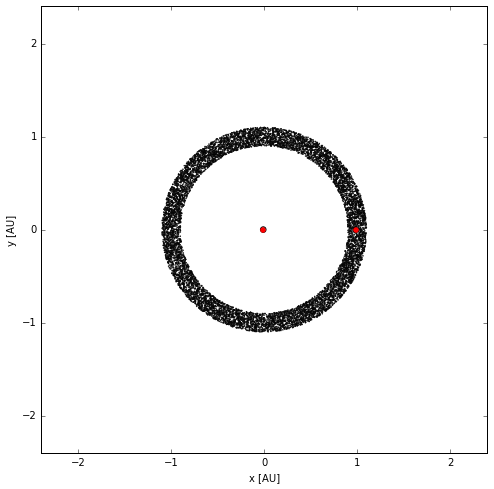

In [15]:
# The plotting function is similar to the one in the saturns_rings.ipynb example.
# It plots all the particles in the simulation, as circles with the radius assigned
# when they were added.  Since we set the planet and star to have r =0.03 we
# can plot them on top of the rest and in a different colour to point them out.
# We also save their indices so we can call on those later to find out where the 
# planet and sun have moved.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plotParticles(sim):
    ID = []
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,aspect='equal')
    ax.set_ylabel("y [AU]")
    ax.set_xlabel("x [AU]")
    ax.set_ylim(-boxsize/2.,boxsize/2.)
    ax.set_xlim(-boxsize/2.,boxsize/2.)

    for i, p in enumerate(sim.particles):
        circ = patches.Circle((p.x, p.y), p.r, facecolor='darkgray', edgecolor='black',zorder=1)
        ax.add_patch(circ)
        if p.r == 0.03:
            ax.scatter(p.x,p.y,color='red',zorder=2)
            ID.append([i])

    return ID

ID = plotParticles(sim) # takes about 20 seconds to plot

In [17]:
# Let's integrate for one orbit and see what the disk of particles looks like after that.

sim.integrate(2.*np.pi)  # takes about 16 seconds per orbit when particles have mass

[[2075], [5987]]

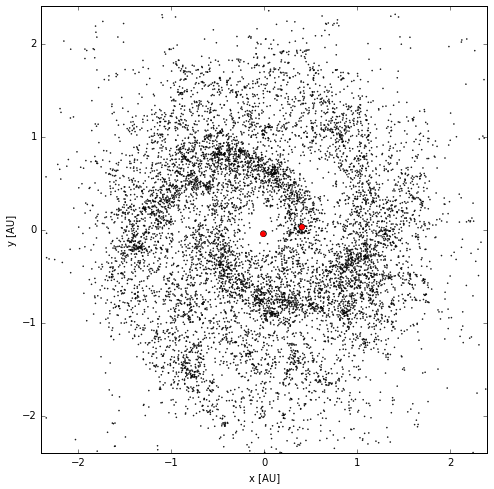

In [18]:
# Plot of particle locations:
plotParticles(sim)

In [26]:
# Since we grabbed the planet and sun indices while we were plotting, we can
# check out what the new distance to the planet is from the sun:
x = sim.particles[2075].x-sim.particles[5987].x
y = sim.particles[2075].y-sim.particles[5987].y
z = sim.particles[2075].z-sim.particles[5987].z
print np.sqrt(x**2 + y**2 + z**2)

0.420784944105


In [30]:
# As you can see, the planet has moved inwards from interactions with the disk of particles!
# Originally at a distance of 1 AU from the central mass, it has moved in to a distance of
# 0.42 AU (this will change values each time you run this.)

# You can also see that the disk has been quite perturbed by the orbiting planet, forming
# lovely density variations at around the radius of the planet's orbit.

In [27]:
# Let's integrate for another orbit and see what happens to the planet and disk after that.

sim.integrate(2.*np.pi*2.)  # takes about 16 seconds per orbit

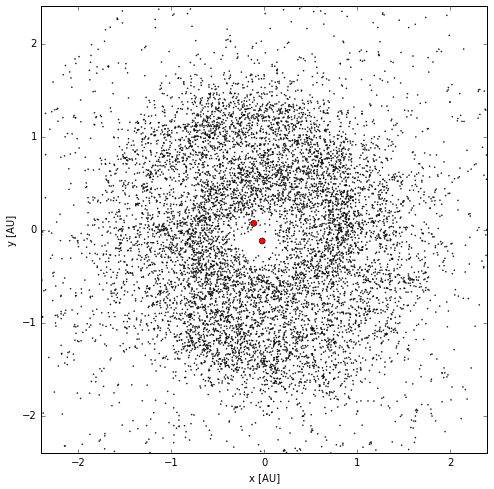

In [28]:
# Let's again plot the simulation with the sun and planet highlighted.
ID = plotParticles(sim)

In [32]:
# As a sidenote, we can double check we have highlighted the correct particles by
# verifying that their masses are those of the sun and planet:
print sim.particles[ID[0][0]].m  # can see that it's the sun
print sim.particles[ID[1][0]].m  # and this one is the planet

1.0
0.01


In [33]:
# distance from the planet to the sun
x = sim.particles[ID[0][0]].x-sim.particles[ID[1][0]].x
y = sim.particles[ID[0][0]].y-sim.particles[ID[1][0]].y
z = sim.particles[ID[0][0]].z-sim.particles[ID[1][0]].z
print np.sqrt(x**2 + y**2 + z**2)

0.210306060555


In [ ]:
# In this run, the planet is even closer to the sun after two orbits.
# The disk has also smoothed out --  the initial density variation
# was due to the spreading of the thin ring and the strong interactions
# when all the particles and the planet were on very close orbits.

# Depending on the initial conditions, the planet either migrates
# inwards or outwards.  It would be nice to set up a statistical analysis of
# this system to find out where the planet is likely to end up, but I didn't
# have time to set up that process for this example.